<a href="https://colab.research.google.com/github/alexaeggers/incentive/blob/main/RL_incentive_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt update
    !apt install python3-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display

    # Start virtual display


    dis = Display(visible=0, size=(400, 400))
    dis.start()

import os
from collections import deque
from typing import Deque, Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import moviepy
import random
import math
import collections
from torch.nn.utils import clip_grad_norm_

# download segment tree module
if IN_COLAB:
    !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py

from segment_tree import MinSegmentTree, SumSegmentTree

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [72.6 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,824 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Get:14

In [ ]:
class DataMarketEnv():
    def __init__(self):
        # Added: 生成6组数据的属性
        self.data_features = []  # [规模, 准确性, 完整性, 一致性, 及时性]
        self.data_prices = []
        for _ in range(6):
            scale = np.random.uniform(1, 10)
            accuracy = np.random.uniform(0.7, 1.0)
            completeness = np.random.uniform(0.8, 1.0)
            consistency = np.random.uniform(0.7, 1.0)
            timeliness = np.random.uniform(0.9, 1.0)
            # 计算初始价格：规模*0.5 + 质量加权分*10
            price = scale*0.5 + 10*(0.3*accuracy + 0.3*completeness + 0.2*consistency + 0.2*timeliness)
            self.data_features.append([scale, accuracy, completeness, consistency, timeliness])
            self.data_prices.append(price)

        self.state = [0] * 29

    def reset(self):
        self.state=[
            0,0,0,0,0,0,  # 数据提供方历史6期 (0-5)
            0,0,0,0,0,0,  # 数据需求方历史6期 (6-11)
            0,0,  # 累计提供次数、需求次数 (12-13)
            0.0,0.0,  # 累计提供价值、需求价值 (14-15)
            0,  # 当前轮次 (16)
            0,0,0,0,0,0, 0,0,0,0,0,0  # 平台激励记录（提供方6期:17-22, 需求方6期:23-28)
        ]

        tree1 = TreeNode1([])
        periods=6
        self.quad_tree = tree1.generate_quad_tree(periods+1)

        # 计算每个节点的state
        tree1.calculate_state(self.quad_tree)

        return self.state, self.quad_tree

    def step(self, action1, action2, data_idx):
        c0 = 10   # 平台固定成本
        c1, c2 = 3, 2  # 提供方和需求方参与成本
        lambda0=1.6
        state=self.state

        history = []
        for kk in range(int(self.state[16])):
            #print("kk",kk)

            index1 = kk
            index2 = index1 + 6
            history.append([self.state[index1], self.state[index2]])
            #print(index1,index2)
        #print(history)

        #先看state[24]等于多少，确定history长度，然后看对应位置的state是多少
        current_price = self.data_prices[data_idx]
        data_value = self._calc_data_value(data_idx)

        optimal_action = update_tree_at_history(
          self.quad_tree, history,
          c1 - action1*0.01,  # 提供方实际成本
          c2 - action2*0.01,  # 需求方实际成本
          current_price,
          data_value
        )
        u_provider, u_buyer = optimal_action

        flag1=1
        flag2=1
        n1=0
        n2=0

        next_state=self.state[0:29]
        next_state[16]=state[16]+1

        # 更新累计量
        if u_provider:
          next_state[12] += 1
          next_state[14] += data_value
        if u_buyer:
          next_state[13] += 1
          next_state[15] += data_value

        if next_state[12]<n1:
          flag1=0
        if next_state[14]<n2:
          flag2=0

        provider_profit = flag1*current_price - (c1-action1*0.01) if u_provider else 0
        buyer_profit = flag2*data_value*0.2 - current_price - (c2-action2*0.01) if u_buyer else 0
        ###参与方的实际收益减去补贴的花销*一定系数，实际社会福利
        platform_profit = current_price*0.05*(u_provider and u_buyer) + (u_provider+u_buyer)*0.3 - c0 - action1*0.01 - action2*0.01

        # 更新状态（移除奖励记录）
        t = int(self.state[16])
        if t < 6:
          next_state[16] += 1
          next_state[t] = u_provider
          next_state[6+t] = u_buyer
          next_state[17+t] = action1
          next_state[23+t] = action2

        self.state=next_state

        #print("next_state",next_state)
        return next_state,platform_profit

    def _calc_data_value(self, idx):
        feat = self.data_features[idx]
        return feat[0] * (0.3*feat[1] + 0.3*feat[2] + 0.2*feat[3] + 0.2*feat[4])

def is_nash_equilibrium(matrix, i, j):
  ###记录第i行，第j列的值

    a_payoff = matrix[i][j][0]
    b_payoff = matrix[i][j][1]

    ###i代表行，j代表列，01代表左右

    for k in range(2):
        ##同列比左
        if matrix[k][j][0] > a_payoff:
            return False
    for k in range(2):
        ##同行比右
        if matrix[i][k][1] > b_payoff:
            return False

    return True


class TreeNode1:
    def __init__(self, action):
        self.action = action
        self.children = []
        self.state = [0,0]
        #二维的state for A , state for B
        self.value = [0,0]
        #二维的value for A , value for B
        self.parent = None
        self.best_child = None
        self.depth=0
        self.path=[]
        self.is_nash = False

    def generate_quad_tree(self, T, depth=0):
        if T == 0:
            return TreeNode1(self.action.copy())  # 注意复制动作列表避免引用问题
            #return None

        # 创建当前节点
        root = TreeNode1(self.action)
        for action_A in [0, 1]:
            for action_B in [0, 1]:
                new_action = self.action + [[action_A, action_B]]
                child = self.generate_quad_tree(T - 1, depth + 1)  # 递归生成子节点

                if child is not None:
                    child.action = new_action
                    child.parent = root
                    root.children.append(child)  # 将子节点添加到当前节点的children中

        return root  # 返回当前节点

    def calculate_state(self, node, depth=0):
        if node.parent and node.parent.state is not None:  # 检查父节点的状态是否已计算
            parent_state = node.parent.state

            if node.action and node.action[0][0] == 0:
                node.state[0] = parent_state[0] + 1
            if node.action and node.action[0][1] == 0:
                node.state[1] = parent_state[1] + 1
            if node.action and node.action[0][0] == 1:
                current_node = node
                actions1 = []
                while current_node:
                    if current_node.action:
                        actions1.insert(0, current_node.action[0][1])  # 将当前节点的动作插入到列表的开头
                    current_node = current_node.parent

                num_ones1 = sum(actions1)  # 统计动作中第一个元素为1的个数
                node.state[0] = depth + num_ones1
            if node.action and node.action[0][1] == 1:
                current_node = node
                actions0 = []
                while current_node:
                    if current_node.action:
                        actions0.insert(0, current_node.action[0][0])  # 将当前节点的动作插入到列表的开头
                    current_node = current_node.parent

                num_ones0 = sum(actions0)  # 统计动作中第一个元素为1的个数
                node.state[1] = depth + num_ones0
        else:
            node.state = [0,0]  # 如果父节点的状态未计算，可以选择默认值或者等待

        for child in node.children:
            child.calculate_state(child,depth+1)

    def select_child(self, values):
        # 过滤掉无效的子节点值
        valid_values = []
        for child in self.children:
            if len(child.value) >= 2:  # 确保value有足够的元素
                valid_values.append( (child.value[0], child.value[1]) )

        # 构建矩阵时动态适应有效子节点数量
        matrix = []
        row = []
        for i, val in enumerate(valid_values):
            if i % 2 == 0 and i != 0:
                matrix.append(row)
                row = []
            row.append(val)
        if row:
            matrix.append(row)

        # 补充矩阵到至少2x2
        while len(matrix) < 2:
            matrix.append([(0,0)] * 2)
        for row in matrix:
            while len(row) < 2:
                row.append((0,0))
        # matrix = [
        # [values[0], values[1]],
        # [values[2], values[3]]
        # ]

        nash_positions = []

        for i in range(2):
            for j in range(2):
                if is_nash_equilibrium(matrix, i, j):
                    nash_positions.append((i, j))
                    self.children[i*2 + j].is_nash=True


        max_payoff = float('-inf')
        selected_child = None

        for i, j in nash_positions:
            total_payoff = sum(matrix[i][j])
            if total_payoff > max_payoff:
                max_payoff = total_payoff



        return i*2 + j

    def calculate_value(self, node, c1, c2, price, value):
        n1 = 0
        n2 = 0

        if not node.children:
            # 原flag逻辑
            flag1 = 1 if node.state[0] >= n1 else 0
            flag2 = 1 if node.state[1] >= n2 else 0

            u1, u2 = node.action[-1] if node.action else [0, 0]
            provider = flag1 * price - c1 * u1 if u1 else 0
            buyer = flag2 * value * 0.2 - price - c2 * u2 if u2 else 0
            node.value = [provider, buyer]
        else:
            for child in node.children:
                self.calculate_value(child, c1, c2, price, value)

            selected_child = node.select_child([(child.value[0], child.value[1]) for child in node.children])  # 传入价值矩阵
            node.best_child = node.children[selected_child]

            if not node.action:
                node.value = node.best_child.value
            else:
                u1, u2 = node.action[-1]
                flag1 = 1 if node.state[0] >= n1 else 0
                flag2 = 1 if node.state[1] >= n2 else 0
                node.value = [
                    flag1 * price - c1 * u1 + 0.9 * node.best_child.value[0],
                    flag2 * value * 0.2 - price - c2 * u2 + 0.9 * node.best_child.value[1]
                ]

def update_tree_at_history(root, history, new_c1, new_c2, price, value):
    current_node = root
    # Traverse the tree based on the history
    if history==[]:
        current_node = root
    else:
        for action in history:
            for child in current_node.children:
                if child.action[0] == action:
                    current_node = child
                    break

    # Update values for the current node's children
    current_node.calculate_value(current_node, new_c1, new_c2, price, value)

    # Recalculate the best child for the current node
    child_values = [(child.value[0], child.value[1]) for child in current_node.children]
    selected_child = current_node.select_child([(child.value[0], child.value[1]) for child in current_node.children])
    current_node.best_child = current_node.children[selected_child]

    # Return the optimal action
    if current_node.best_child:
        return current_node.best_child.action[-1]
    else:
        return None

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""
    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        n_step: int = 1,
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, 2], dtype=np.int32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.data_idx_buf = np.zeros(size, dtype = np.int32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self,
        obs: np.ndarray,
        act: Tuple[int, int],
        data_idx: int,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, data_idx, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()

        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act, data_idx = self.n_step_buffer[0][:3]

        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act  # 编码后的动作
        self.data_idx_buf[self.ptr] = data_idx  # 数据索引
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            data_idx = self.data_idx_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )

    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        acts = self.acts_buf[idxs]          # 形状为 (batch_size, 2)
        acts_provider = acts[:, 0]          # 提供方动作
        acts_buyer = acts[:, 1]             # 需求方动作
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts_provider=acts_provider,    # 添加键名
            acts_buyer=acts_buyer,          # 添加键名
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            data_idx = self.data_idx_buf[idxs],
        )

    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

In [ ]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.

    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight

    """

    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        alpha: float = 0.6,
        n_step: int = 1,
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0

        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
        self,
        obs: np.ndarray,
        act: Tuple[int, int],  # 双动作
        data_idx: int,         # 新增数据索引
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """存储双动作和数据索引，并设置初始优先级"""
        # 编码动作：action1*100 + action2（确保无冲突）
        #act_encoded = act[0] * 100 + act[1]
        # 调用父类方法存储（需确保父类已适配新参数）
        transition = super().store(obs, act, data_idx, rew, next_obs, done)

        if transition:
            # 设置初始优先级
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()


        acts = self.acts_buf[indices]      # 编码后的动作（action1*100 + action2）

        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        # 解码动作
        acts_provider = acts[:, 0]  # 取第一个元素
        acts_buyer = acts[:, 1]     # 取第二个元素           # 需求方激励 action2

        return dict(
            obs = self.obs_buf[indices],
            next_obs = self.next_obs_buf[indices],
            acts_provider=acts_provider,           # 返回解码后的双动作
            acts_buyer=acts_buyer,
            data_idx = self.data_idx_buf[indices],     # 数据索引
            rews = self.rews_buf[indices],
            done = self.done_buf[indices],
            weights=weights,
            indices=indices,
        )

    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

In [ ]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.



    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter

    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.

        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

In [ ]:
class Network(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 290),
            nn.ReLU(),
        )

        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(290, 40)
        # self.advantage_layer = NoisyLinear(40, 92)  # 原46改为92
        self.advantage_layer = NoisyLinear(40, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(290, 40)
        self.value_layer = NoisyLinear(40, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)

        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

In [ ]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """

    def __init__(
        self,
        env,
        #env改为泛型
        memory_size: int,
        batch_size: int,
        target_update: int,


        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,

        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = 29
        action_dim = 46

        self.env = env

        self.batch_size = batch_size

        self.target_update = target_update
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha, gamma=gamma
        )

        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )

        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> Tuple[int, int]:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        with torch.no_grad():
            q_values = self.dqn(torch.FloatTensor(state).unsqueeze(0).to(self.device))
            composite_action = q_values.argmax().item()
            # 解码为双动作
            action_provider = composite_action // 46  # 提供方动作
            action_buyer = composite_action % 46     # 需求方动作
            return action_provider, action_buyer

        # selected_action = self.dqn(torch.FloatTensor(np.array([state])).to(self.device)).argmax()
        # selected_action = selected_action.detach().cpu().numpy()


        # if not self.is_test:
        #     self.transition = [state, selected_action]

        # return selected_action

    def step(self, action_provider: int, action_buyer: int, data_idx: int, current_state: np.ndarray):
        """Take an action and return the response of the env."""
        next_state, reward = self.env.step(action_provider, action_buyer, data_idx)
        done = (self.env.state[16] >= 6)  # 假设第16位是当前轮次

        if not self.is_test:

            self.transition = [
                current_state,  # 当前状态obs
                (action_provider, action_buyer),  # 双动作
                data_idx,    # 数据索引
                reward,      # 奖励
                next_state,  # 下一状态
                done         # 是否终止
            ]

            # Modified: 存储双动作和数据索引
            #self.transition += [(action_provider, action_buyer), data_idx, reward, next_state, done]

            # N-step 处理（若有）
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            else:
                one_step_transition = self.transition

            if one_step_transition:
                self.memory.store(*one_step_transition)
        return next_state, reward, done

    def update_model(self):
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]

        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)

        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)

        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss

            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 1000):
        """Train the agent."""
        self.is_test = False
        state = env.reset()[0]
        quad_tree=env.reset()[1]

        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            data_idx = np.random.randint(0, 6)  # 随机选择0~5号数据
            done = False

            while not done:
                action_provider, action_buyer = self.select_action(state)
                next_state, reward, done = self.step(action_provider, action_buyer, data_idx, state)

                if not self.is_test:
                    self.transition = [
                        state,
                        (action_provider, action_buyer),
                        data_idx,
                        reward,
                        next_state,
                        done
                    ]

                    # N-step Learning处理
                    if self.use_n_step:
                        transition = self.memory_n.store(*self.transition)
                    else:
                        transition = self.transition

                    # 存入主经验池
                    if transition:
                        self.memory.store(*transition)

                state = next_state
                score += reward  # 直接累加奖励（无折扣）

                if len(self.memory) >= self.batch_size:
                    loss = self.update_model()
                    losses.append(loss)
                    update_cnt += 1

                    # 定期同步目标网络
                    if update_cnt % self.target_update == 0:
                        self._target_hard_update()

                # PER参数beta动态调整
                fraction = min(frame_idx / num_frames, 1.0)
                self.beta = self.beta + fraction * (1.0 - self.beta)

            if done:
              state = self.env.reset()[0]
              quad_tree = self.env.reset()[1]
              scores.append(score)
              score = 0

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                self.test()

    def test(self):
        """Test the agent."""
        self.is_test = True
        state = self.env.reset()[0]
        quad_tree = self.env.reset()[1]
        data_idx = np.random.randint(0, 6)  # 随机选择一个数据
        current_price = self.env.data_prices[data_idx]
        data_value = self.env._calc_data_value(data_idx)

        print(f"\n=== 测试数据 {data_idx} ===")
        print(f"数据价格: {current_price:.2f}, 数据价值: {data_value:.2f}")
        print(f"属性: 规模={self.env.data_features[data_idx][0]:.2f}, 准确性={self.env.data_features[data_idx][1]:.2f}")

        lambda0=1.6

        total_reward = 0
        for step in range(6):
            action1, action2 = self.select_action(state)
            next_state, reward, done = self.step(action1, action2, data_idx, state)

            # 解析参与情况
            u_provider = next_state[step]          # 提供方是否参与
            u_buyer = next_state[6 + step]         # 需求方是否参与
            incentive1 = action1 * 0.01            # 提供方实际激励
            incentive2 = action2 * 0.01            # 需求方实际激励

            print(
                f"轮次 {step+1}: "
                f"激励=({incentive1:.2f}, {incentive2:.2f}), "
                f"参与情况=({u_provider}, {u_buyer}), "
                f"平台收益={reward:.2f}"
            )

            state = next_state
            total_reward += reward
            if done:
                break

        print(f"总平台收益: {total_reward:.2f}\n")
        self.is_test = False

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action_provider = torch.LongTensor(samples["acts_provider"]).to(device)
        action_buyer = torch.LongTensor(samples["acts_buyer"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        composite_action = action_provider * 46 + action_buyer

        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), composite_action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        #clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(122)
        plt.title('loss')
        plt.plot(losses)

        plt.show()

In [ ]:
# parameters
num_frames = 10000
memory_size = 10000
batch_size = 128
target_update = 100

env=DataMarketEnv()
# train
agent = DQNAgent(env, memory_size, batch_size, target_update)

cpu


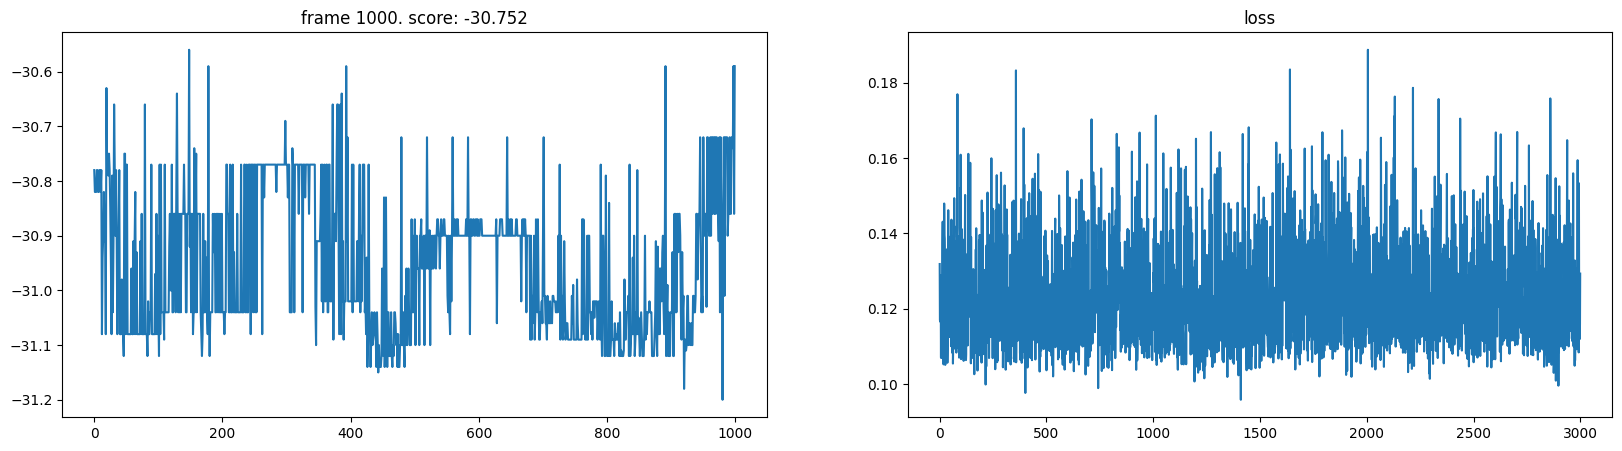


=== 测试数据 1 ===
数据价格: 10.29, 数据价值: 1.66
属性: 规模=1.77, 准确性=0.97
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.42), 参与情况=(0, 0), 平台收益=-10.42
轮次 3: 激励=(0.00, 0.42), 参与情况=(0, 0), 平台收益=-10.42
总平台收益: -31.20



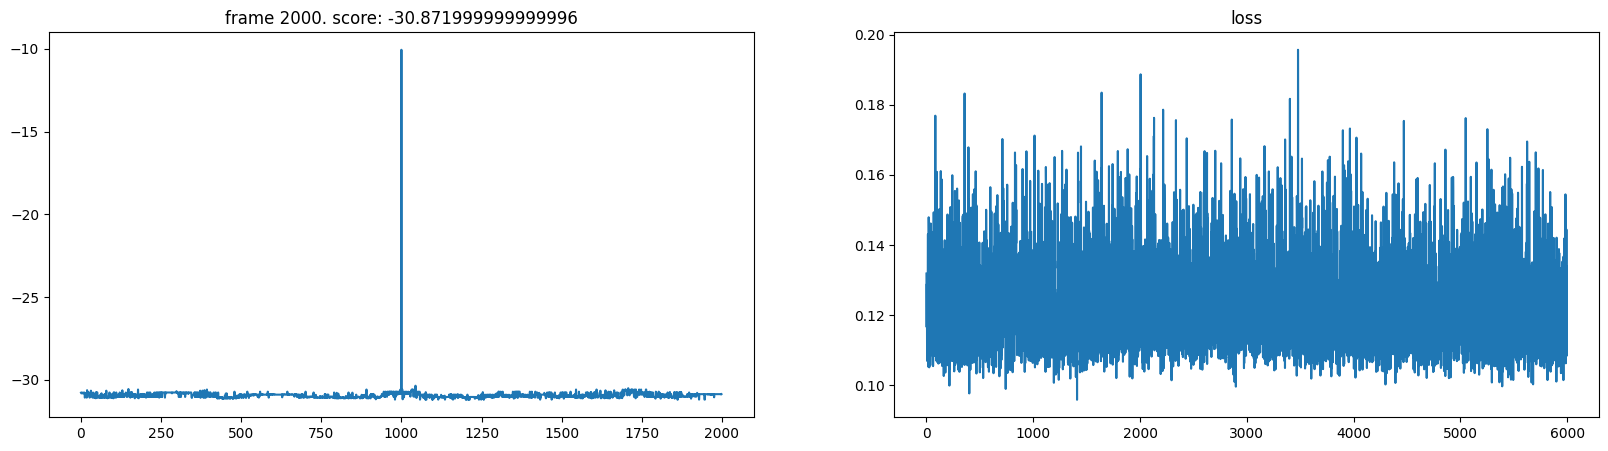


=== 测试数据 2 ===
数据价格: 12.63, 数据价值: 6.56
属性: 规模=7.30, 准确性=0.81
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.33), 参与情况=(0, 0), 平台收益=-10.33
轮次 3: 激励=(0.00, 0.18), 参与情况=(0, 0), 平台收益=-10.18
总平台收益: -30.87



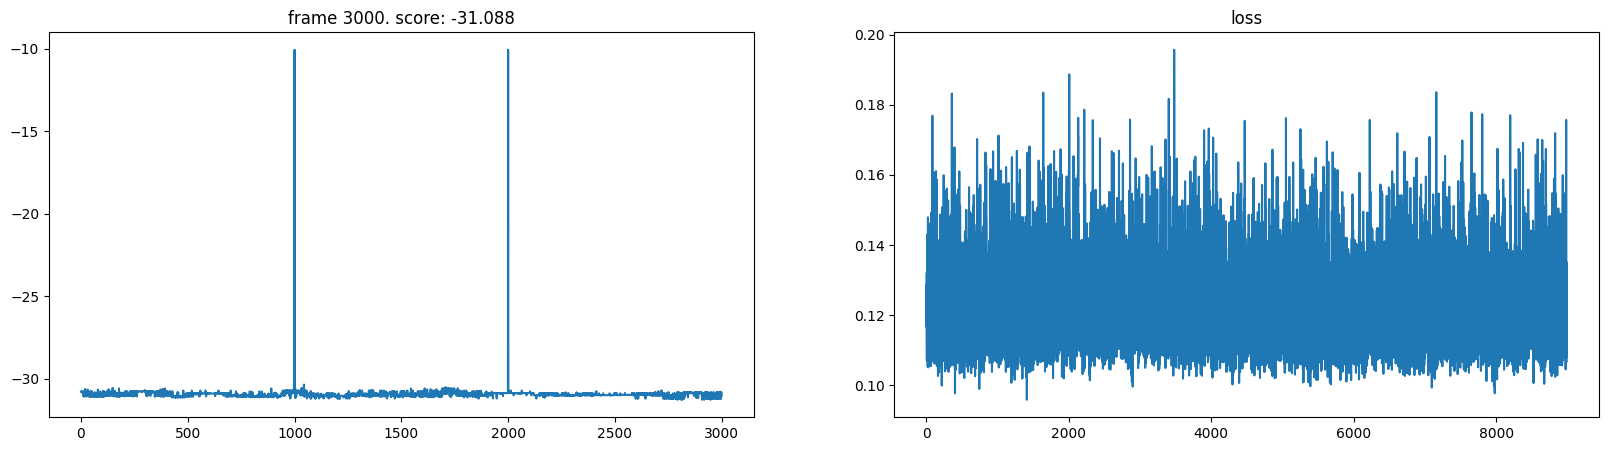


=== 测试数据 2 ===
数据价格: 12.63, 数据价值: 6.56
属性: 规模=7.30, 准确性=0.81
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.43), 参与情况=(0, 0), 平台收益=-10.43
轮次 3: 激励=(0.00, 0.02), 参与情况=(0, 0), 平台收益=-10.02
总平台收益: -30.81



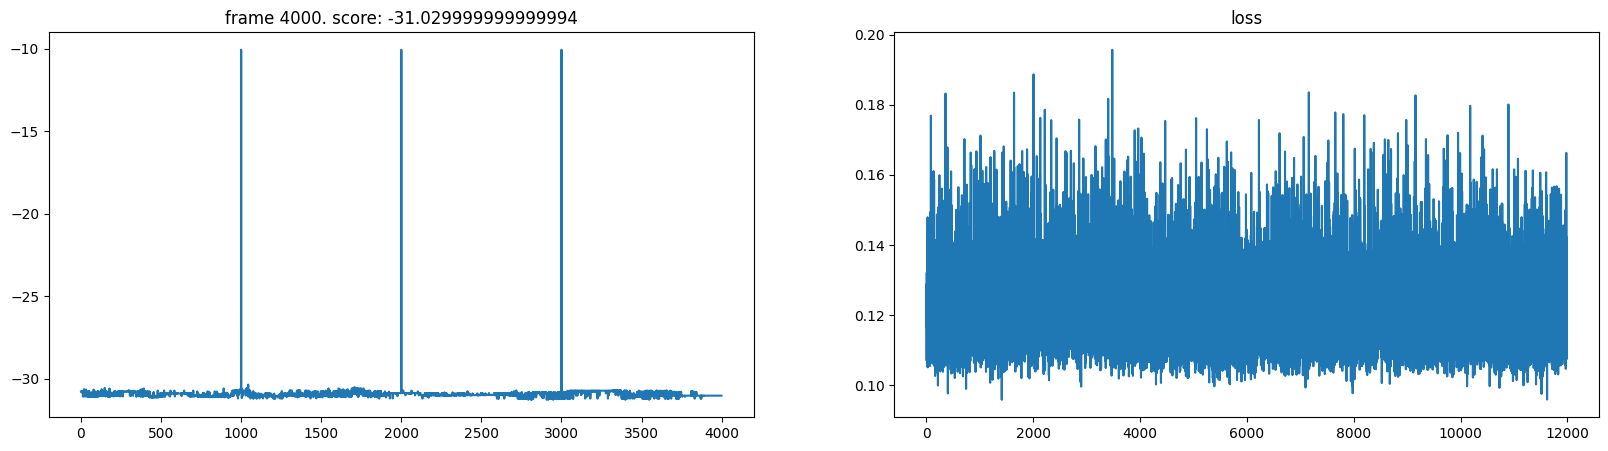


=== 测试数据 1 ===
数据价格: 10.29, 数据价值: 1.66
属性: 规模=1.77, 准确性=0.97
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.35), 参与情况=(0, 0), 平台收益=-10.35
轮次 3: 激励=(0.00, 0.32), 参与情况=(0, 0), 平台收益=-10.32
总平台收益: -31.03



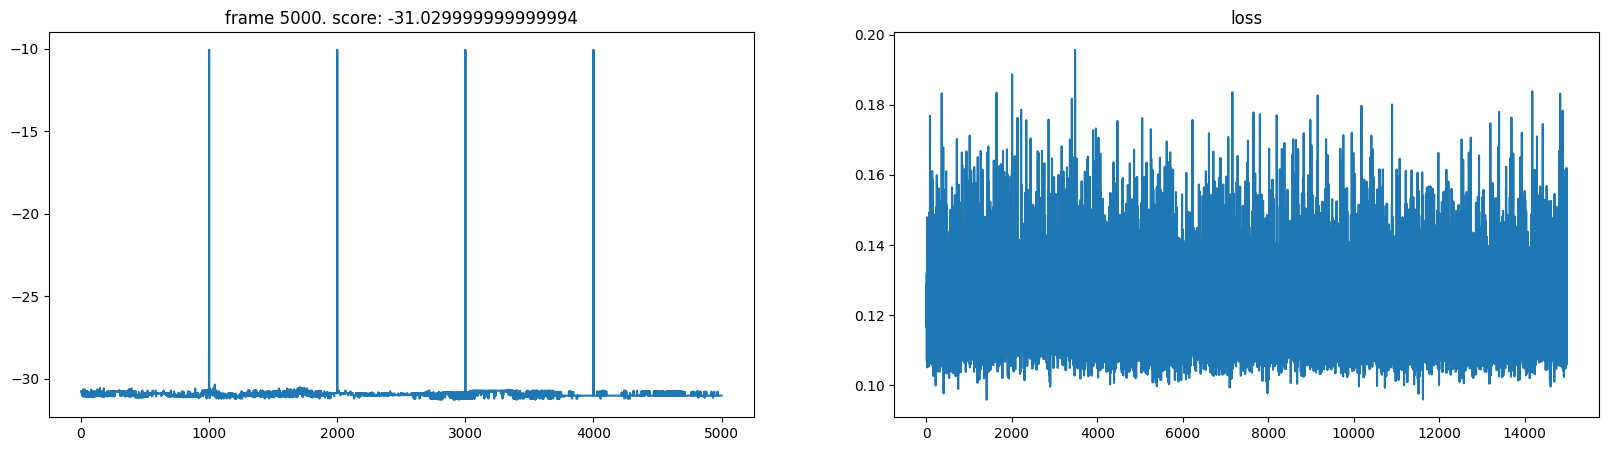


=== 测试数据 2 ===
数据价格: 12.63, 数据价值: 6.56
属性: 规模=7.30, 准确性=0.81
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.35), 参与情况=(0, 0), 平台收益=-10.35
轮次 3: 激励=(0.00, 0.32), 参与情况=(0, 0), 平台收益=-10.32
总平台收益: -31.03



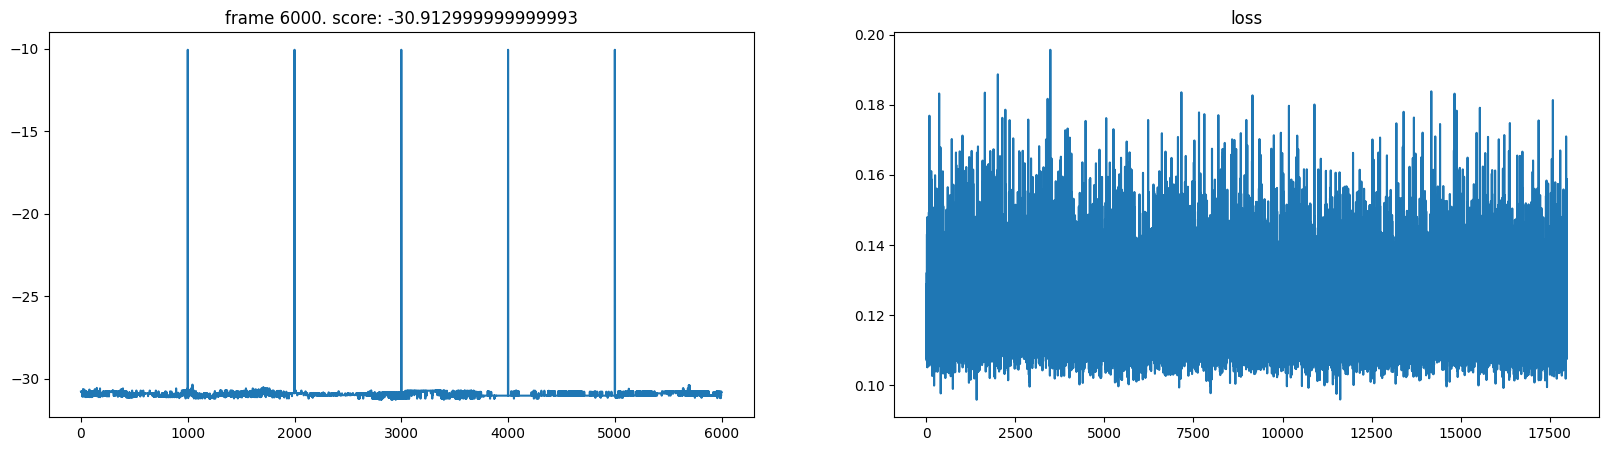


=== 测试数据 3 ===
数据价格: 9.91, 数据价值: 2.14
属性: 规模=2.46, 准确性=0.91
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.37), 参与情况=(0, 0), 平台收益=-10.37
轮次 3: 激励=(0.00, 0.08), 参与情况=(0, 0), 平台收益=-10.08
总平台收益: -30.81



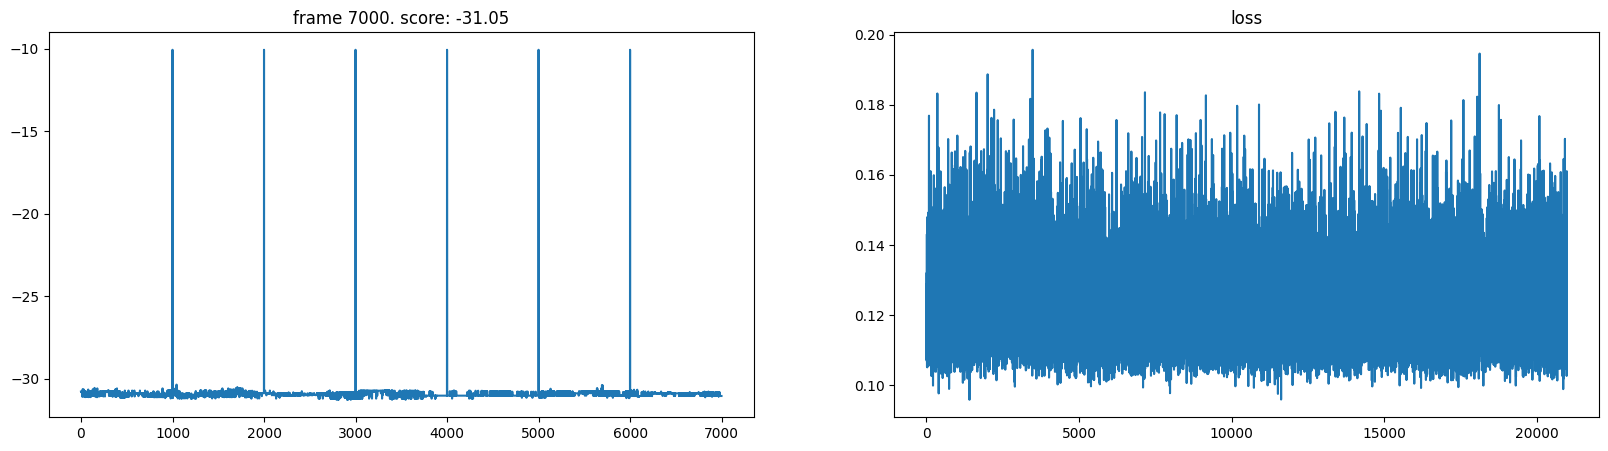


=== 测试数据 2 ===
数据价格: 12.63, 数据价值: 6.56
属性: 规模=7.30, 准确性=0.81
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.37), 参与情况=(0, 0), 平台收益=-10.37
轮次 3: 激励=(0.00, 0.32), 参与情况=(0, 0), 平台收益=-10.32
总平台收益: -31.05



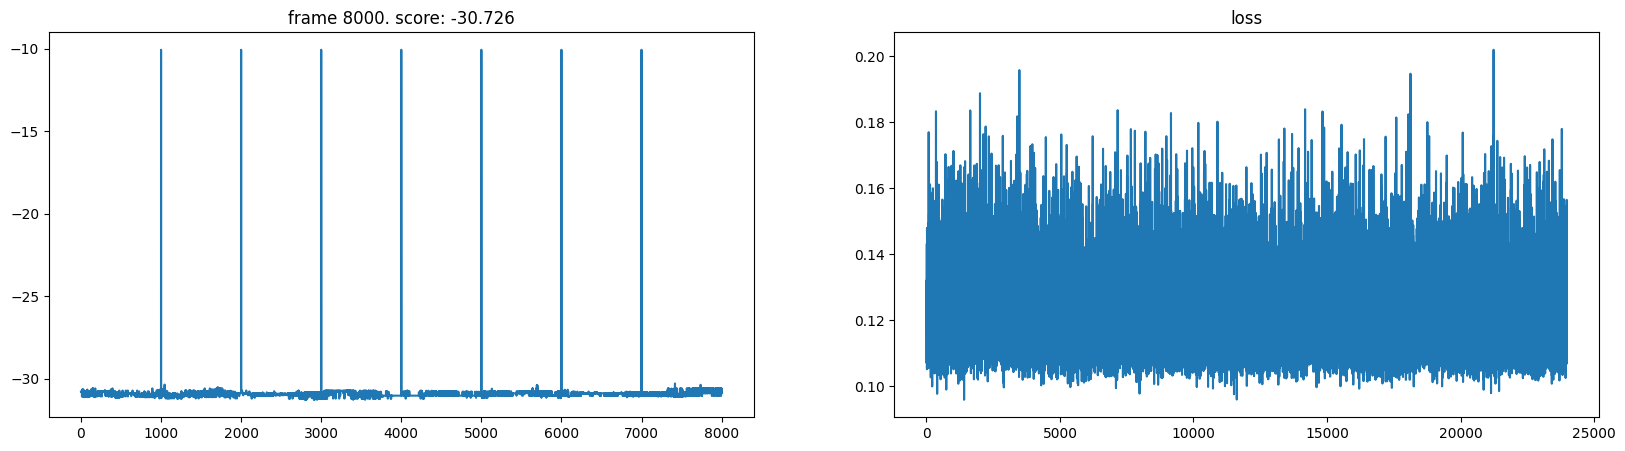


=== 测试数据 4 ===
数据价格: 12.71, 数据价值: 6.96
属性: 规模=7.98, 准确性=0.84
轮次 1: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
轮次 2: 激励=(0.00, 0.15), 参与情况=(0, 0), 平台收益=-10.15
轮次 3: 激励=(0.00, 0.07), 参与情况=(0, 0), 平台收益=-10.07
总平台收益: -30.58



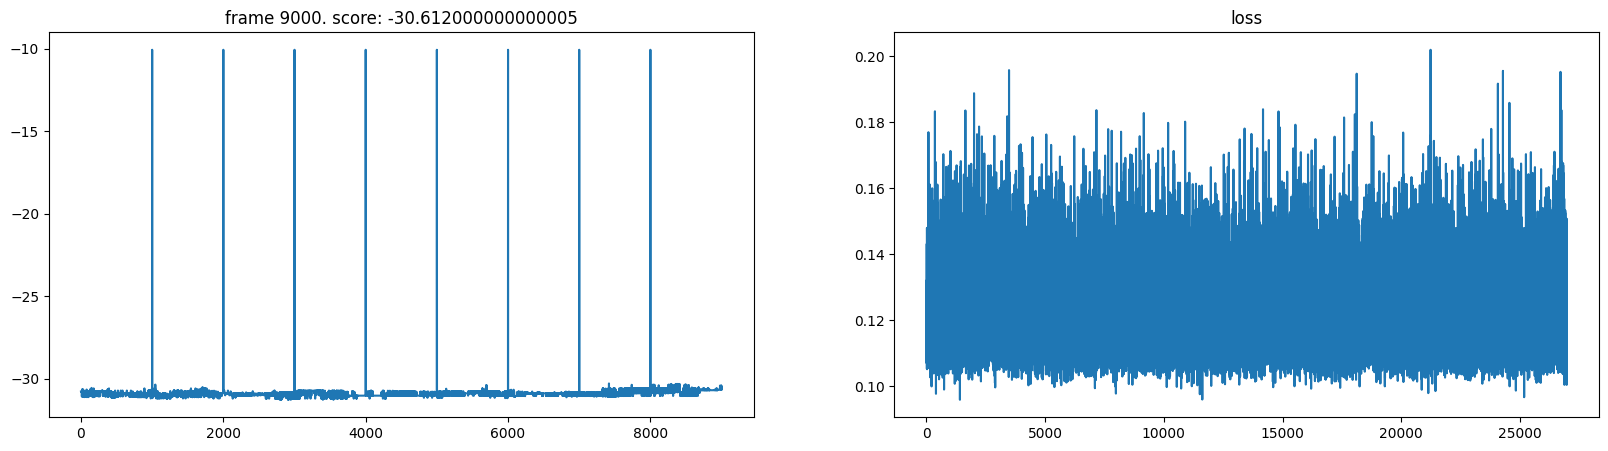


=== 测试数据 3 ===
数据价格: 9.91, 数据价值: 2.14
属性: 规模=2.46, 准确性=0.91
轮次 1: 激励=(0.00, 0.19), 参与情况=(0, 0), 平台收益=-10.19
轮次 2: 激励=(0.00, 0.19), 参与情况=(0, 0), 平台收益=-10.19
轮次 3: 激励=(0.00, 0.08), 参与情况=(0, 0), 平台收益=-10.08
总平台收益: -30.46



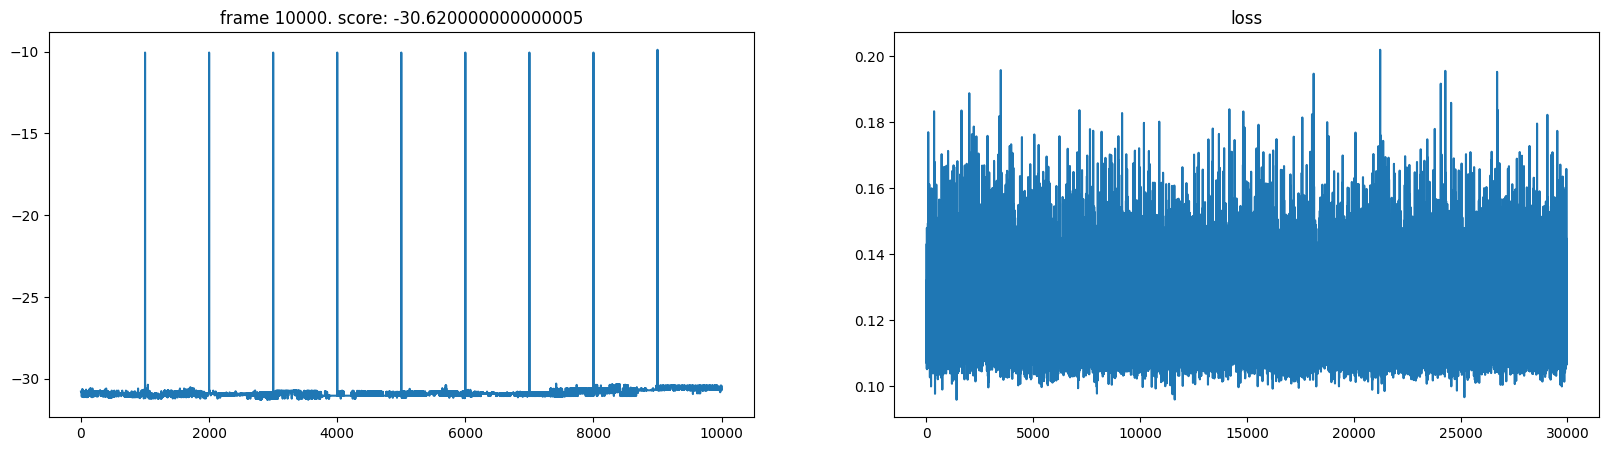


=== 测试数据 2 ===
数据价格: 12.63, 数据价值: 6.56
属性: 规模=7.30, 准确性=0.81
轮次 1: 激励=(0.00, 0.19), 参与情况=(0, 0), 平台收益=-10.19
轮次 2: 激励=(0.00, 0.19), 参与情况=(0, 0), 平台收益=-10.19
轮次 3: 激励=(0.00, 0.32), 参与情况=(0, 0), 平台收益=-10.32
总平台收益: -30.70



In [ ]:
agent.train(num_frames)

In [ ]:
agent.test()


=== 测试数据 0 ===
数据价格: 10.64, 数据价值: 3.11
属性: 规模=3.49, 准确性=0.76
轮次 1: 激励=(0.00, 0.24), 参与情况=(0, 0), 平台收益=-10.24
轮次 2: 激励=(0.00, 0.18), 参与情况=(0, 0), 平台收益=-10.18
轮次 3: 激励=(0.00, 0.36), 参与情况=(0, 0), 平台收益=-10.36
总平台收益: -30.78

